In [1]:
#https://docs.ray.io/en/latest/train/examples/train_fashion_mnist_example.html

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage

from sklearn.metrics import classification_report, confusion_matrix

import ray
from ray import train
from ray import tune
import ray.train.torch
from ray.train import Trainer
from ray.train import CheckpointStrategy
from ray.data.datasource import SimpleTorchDatasource

import matplotlib.pyplot as plt

from ray_cluster_control import start_ray_cluster, stop_ray_cluster

/opt/app-root/lib64/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
start_ray_cluster()

In [4]:
ray.init('ray://{ray_head}-ray-head:10001'.format(ray_head=os.environ['RAY_CLUSTER_NAME']))

ClientContext(dashboard_url='10.128.2.92:8265', python_version='3.8.12', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', protocol_version='2022-03-16', _num_clients=1, _context_to_restore=<ray.util.client._ClientContext object at 0x7fc71b75cbe0>)

In [5]:
transforms = Compose([Resize((64,64)),ToTensor()])

In [6]:
pet_data = torchvision.datasets.OxfordIIITPet("data/",download = True ,  target_types = "category", transform = transforms, split = "trainval")

In [7]:
data_loader = torch.utils.data.DataLoader(pet_data, batch_size=4, shuffle=True)

This data set is only 3K and not the full 7k since we read in dataset with the `split` parameters that pulls in the files based on the corresponding txt file in `data/data/oxford-iiit-pet/annotations`

In [8]:
len(pet_data)

3680

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = "cpu"

cpu


Feature batch shape: torch.Size([4, 3, 64, 64])
Labels batch shape: torch.Size([4])


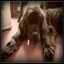

label:22


In [10]:
train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')

In [11]:
# modified from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3,1 )
        
        self.fc1 = nn.Linear(6272 , 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 37)
        
        self.dropout1 = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool((self.conv1(x)))
        x = self.pool((self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        y_pred = self.fc3(x)
        return y_pred



In [12]:
net = ConvNet()
net.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=37, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
def train_x(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [15]:
%time
for epoch in range(2):
    train_x(net,device,data_loader, optimizer, epoch) 
    
state_dict = net.state_dict()
consume_prefix_in_state_dict_if_present(state_dict, "module.")        

print('Finished Training')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Train Epoch: 0 [0/3680 (0%)]	Loss: 3.656356
Train Epoch: 1 [0/3680 (0%)]	Loss: 3.558275
Finished Training


In [16]:
model_scripted = torch.jit.script(net)
model_scripted.save('model_scripted.pt')

In [17]:
# Now with Ray 

In [18]:
dataset_factory = lambda: torchvision.datasets.OxfordIIITPet("data/", download = True, target_types = "category", transform = transforms, split = "trainval")
dataset = ray.data.read_datasource(
    SimpleTorchDatasource(), parallelism=1, dataset_factory=dataset_factory
)

Caught schedule exception


In [19]:
x = dataset.random_shuffle().repartition(2).split(2)
x

2022-09-01 18:12:15,370	INFO common.py:219 -- Exception from actor creation is ignored in destructor. To receive this exception in application code, call a method on the actor reference before its destructor is run.
Repartition: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[Dataset(num_blocks=1, num_rows=1840, schema=<class 'tuple'>),
 Dataset(num_blocks=1, num_rows=1840, schema=<class 'tuple'>)]

In [20]:
train_data = x[0]
test_data = x[1]

In [21]:
def train_epoch(dataloader, model, loss_fn, optim):
    model.train()
    model.to("cuda")
    for batch_idx, data in enumerate(dataloader.iter_batches()):
        X = [x[0] for x in data]
        X = torch.stack(X)
        X = X.to("cuda")
        y = [torch.tensor(x[1]) for x in data]
        y = torch.stack(y)
        y = y.to("cuda") 
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return loss.item()

In [22]:
def validate_epoch(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader.iter_batches():
            X = [x[0] for x in data]
            X = torch.stack(X)
            X = X.to("cuda")
            y = [torch.tensor(x[1]) for x in data]
            y = torch.stack(y)
            y = y.to("cuda")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()  
    
    return test_loss/dataloader.num_blocks()

            

In [23]:
# Define a search space.
search_space = {
    "lr": tune.grid_search([0.001, 0.1]),
    "momentum": tune.grid_search([0.1, 0.9]),
    "batch_size": tune.grid_search([4]), 
    "epochs": tune.grid_search([300]),
    "tune_run": tune.grid_search([True])
    
}

In [24]:
def train_func(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]
    momentum = config["momentum"]
    tune_run = config["tune_run"]
    
    
    train_dataloader = train_data
    test_dataloader = test_data
    model = ConvNet()
    #model = train.torch.prepare_model(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,  momentum=momentum)
    
    loss_results = []
    eval_results = []
    
    for epoch in range(epochs):
        loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        val_loss = validate_epoch(test_dataloader, model, loss_fn)
        #train.report(loss=val_loss)
        loss_results.append(loss)
        eval_results.append(val_loss)
        if not tune_run:
            if epoch % 100 == 0:
                print(f"epoch:{epoch}  loss {loss:>7f}")
                print(f"eval loss: {val_loss:>7f}")    

            if epoch == epochs-1:
                state_dict = model.state_dict()
                consume_prefix_in_state_dict_if_present(state_dict, "module.")
                train.save_checkpoint(epoch=epochs, model_weights=state_dict)
    
    if tune_run:
        tune.report(loss=loss)
    
    return loss_results, eval_results
            
    

In [25]:
# Tune! 

In [ ]:
analysis = tune.run(tune.with_parameters(train_func), config=search_space, resources_per_trial={'gpu': 1})
print(analysis.get_best_config(metric="loss", mode="min"))

In [27]:
# Now that we know best param, we'll train and save our model. This prevents us from saving N model trails that we'll need to deleted later.  

In [28]:
%%time
if os.environ.get('RAY_CLUSTER_NAME') is not None:
    num_workers = 2
else:
    num_workers = 1
    

trainer = Trainer(backend="torch", num_workers=num_workers, use_gpu=True)

(run pid=1711) 2022-09-01 18:16:07,526	INFO tune.py:747 -- Total run time: 214.67 seconds (214.43 seconds for the tuning loop).
2022-09-01 18:16:07,578	INFO trainer.py:243 -- Trainer logs will be logged in: /opt/app-root/src/ray_results/train_2022-09-01_18-16-07


CPU times: user 7.45 ms, sys: 974 µs, total: 8.42 ms
Wall time: 16.1 ms


In [ ]:
%%time
trainer.start()# This keeps starting new workers 

In [30]:
config = analysis.get_best_config(metric="loss", mode="min")
config["tune_run"] = False

In [ ]:
%%time
loss, eval_ = trainer.run(train_func=train_func,
                          config = config)


In [32]:
results = trainer.latest_checkpoint

In [33]:
%%time
trainer.shutdown()

CPU times: user 2.11 ms, sys: 25 µs, total: 2.13 ms
Wall time: 30 ms


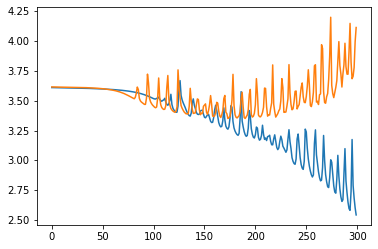

In [44]:
plt.plot(loss[0])
plt.plot(eval_[1])
plt.show()

In [35]:
model = ConvNet()
model.load_state_dict(results["model_weights"])
model_scripted = torch.jit.script(model)
model_scripted.save('models/ray_model_scripted.pt')

In [36]:
model = torch.jit.load("models/ray_model_scripted.pt", map_location=torch.device('cpu')).eval()

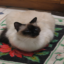

label:6
prediction: 11


In [37]:
train_features, train_labels = next(iter(data_loader))
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')
logits = model(train_features[0].reshape(1,3,64,64).to(device))
print(f"prediction: {torch.argmax(logits).item()}")

In [38]:
y_preds = []
gt = []
for X,y in data_loader:
    logits = model(X[0].reshape(1,3,64,64).to(device))
    y_pred = torch.argmax(logits).item()
    y_preds.append(y_pred)
    gt.append(y[0].item())

In [39]:
for data in test_data.iter_batches():
    X = [x[0] for x in data]
    X = torch.stack(X)
    X = X.to("cpu")
    y = [torch.tensor(x[1]) for x in data]
    y = torch.stack(y)
    logits = model(X.to(device))
    y_preds = torch.argmax(logits, dim=1)
    y_preds = y_preds.to("cpu")

In [40]:
print(classification_report(y_preds,y))

              precision    recall  f1-score   support

           0       0.06      0.07      0.07        43
           1       0.12      0.11      0.11        55
           2       0.00      0.00      0.00        65
           3       0.14      0.11      0.12        64
           4       0.04      0.04      0.04        49
           5       0.02      0.05      0.03        22
           6       0.05      0.04      0.04        53
           7       0.32      0.25      0.28        71
           8       0.05      0.07      0.06        44
           9       0.06      0.06      0.06        53
          10       0.06      0.05      0.05        64
          11       0.06      0.12      0.08        24
          12       0.04      0.04      0.04        49
          13       0.08      0.07      0.08        55
          14       0.14      0.09      0.11        68
          15       0.20      0.13      0.16        75
          16       0.00      0.00      0.00        24
          17       0.14    

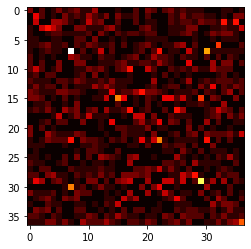

In [41]:
plt.imshow(confusion_matrix(y_preds,y), cmap='hot', interpolation='nearest')
plt.show()

In [42]:
print(f"Accuracy: {np.sum(np.array(y_preds)==np.array(y))/(len(y))*100:.1f}%")
print(f"Random guess would yield {(1/37)*100:.1f}%")
print(f"Model outperforms Random chance by a factor of {(np.sum(np.array(y_preds)==np.array(y))/len(y))/(1/37):.2f}")

Accuracy: 8.9%
Random guess would yield 2.7%
Model outperforms Random chance by a factor of 3.28


In [43]:
stop_ray_cluster()

Log channel is reconnecting. Logs produced while the connection was down can be found on the head node of the cluster in `ray_client_server_[port].out`
2022-09-01 18:19:53,397	WARNING dataclient.py:363 -- Encountered connection issues in the data channel. Attempting to reconnect.


done


2022-09-01 18:20:23,603	WARNING dataclient.py:370 -- Failed to reconnect the data channel
